# Data Analysis
### Predictive modelling of stroke occurences

Import libraries

In [1]:
import pandas as pd
from utils import DataLoader, Performance, InterpretModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('once')
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

c:\Users\Bruger\anaconda3\envs\datascience\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load data

In [2]:
data_loader = DataLoader("healthcare-dataset-stroke-data.csv")
data_loader.load_dataset()

# Preprocess data
- Using the preprocessing pipeline from Utils based on the findings from the data exploration 
- Undersample to account for the imbalance in the data set

In [3]:
data_loader.preprocess_data()
# Split the data for testing and training for ANN 
X_train, X_test, X_val, y_train, y_test, y_val = data_loader.get_data_split(ANN = True)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# Oversample the train data 
X_train, y_train = data_loader.undersample(X_train, y_train)
print("After undersampling:", X_train.shape)

(3065, 20)
(1022, 20)
(1022, 20)
After undersampling: (308, 20)


In [4]:
# Check data
X_train

,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,13.0,0.0,0.0,73.76,26.7
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,46.0,0.0,0.0,180.45,22.5
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,27.0,0.0,0.0,126.09,25.1
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,45.0,0.0,0.0,58.25,24.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,13.0,0.0,0.0,69.16,22.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,80.0,1.0,0.0,74.90,22.2
304,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,74.0,0.0,0.0,98.55,25.6
305,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,80.0,0.0,0.0,104.12,23.5
306,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,76.0,0.0,0.0,57.92,28.1


## Fit models
- ANN
- Random Forest
- XGBoost

### ANN

In [5]:
#Scale and Fit the data
# Scaling is needed which it is not for random forest or XGBoost
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.random.set_seed(2)

the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
HAMMING is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.HAMMING instead.
BOX is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BOX instead.
LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


#### Define model

In [7]:
#ANN MODEL
model = Sequential()

model.add(Dense(units = 14, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units = 7, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units = 3, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy') # metrics=[tf.keras.metrics.FalsePositives()]

#### Define early stopping callback

In [8]:
#stops when validation loss is not dropping for 3 epochs
#early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1)
# Rule of thumb, patience is 10% of the number of epochs 
# We need to save the model 
callbacks = [EarlyStopping(monitor='val_loss', patience=12),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

#### Fit model

In [9]:
#Fitting model
model.fit(X_train_scaled, y_train, 
          epochs = 150,
         validation_data=(X_val_scaled, y_val),
         verbose = 1, 
         callbacks=callbacks, batch_size=30)

Epoch 1/150
11/11 [==============================] - 1s 35ms/step - loss: 0.6897 - accuracy: 0.5065 - val_loss: 0.6445 - val_accuracy: 0.9540
Epoch 2/150
11/11 [==============================] - 0s 9ms/step - loss: 0.6925 - accuracy: 0.5065 - val_loss: 0.6447 - val_accuracy: 0.9540
Epoch 3/150
11/11 [==============================] - 0s 12ms/step - loss: 0.6895 - accuracy: 0.5195 - val_loss: 0.6435 - val_accuracy: 0.4980
Epoch 4/150
11/11 [==============================] - 0s 12ms/step - loss: 0.6813 - accuracy: 0.5519 - val_loss: 0.6398 - val_accuracy: 0.5049
Epoch 5/150
11/11 [==============================] - 0s 12ms/step - loss: 0.6822 - accuracy: 0.5779 - val_loss: 0.6370 - val_accuracy: 0.5176
Epoch 6/150
11/11 [==============================] - 0s 13ms/step - loss: 0.6792 - accuracy: 0.5422 - val_loss: 0.6342 - val_accuracy: 0.5313
Epoch 7/150
11/11 [==============================] - 0s 14ms/step - loss: 0.6743 - accuracy: 0.5909 - val_loss: 0.6286 - val_accuracy: 0.5597
Epoch 8

Text(0.5, 1.0, 'Training loss and accuracies')

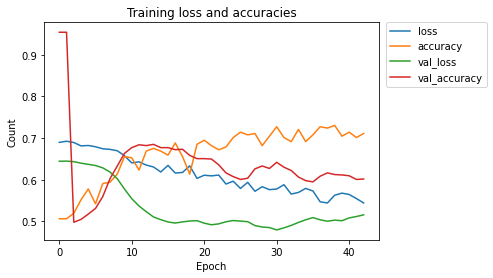

In [10]:
# Visualize training
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Epoch")
plt.ylabel("Count")
plt.title("Training loss and accuracies")

##### Performance of ANN model

In [11]:
# First we load the best model
from keras.models import load_model
saved_model = load_model('best_model.h5')

#Predictions
prediction_values = saved_model.predict(X_test_scaled)
# Convert into classes 
prediction_best = []
for i in prediction_values:
    prediction_best.append(np.where(i > 0.5, 1,0)[0])

performance = Performance()
saved_model_performance = performance.evaluate(test_labels = y_test, predictions = prediction_best)

32/32 [==============================] - 0s 2ms/step
Model Performance
Accuracy = 62.33%.
Recall strokes only = 82.35%.


We also check the last model since we were optimizing for accuracy, the recall of strokes might be better here

In [12]:
#Predictions
prediction_values = model.predict(X_test_scaled)
# Convert into classes 
prediction = []
for i in prediction_values:
    prediction.append(np.where(i > 0.5, 1,0)[0])

model_performance = performance.evaluate(test_labels = y_test, predictions = prediction)

32/32 [==============================] - 0s 2ms/step
Model Performance
Accuracy = 59.10%.
Recall strokes only = 84.31%.


Since this model did perform better in terms of recalling strokes we choose th elast model as the best model. 

We make classification report and confusion matrix

In [13]:
print(classification_report(y_test,prediction))

cf = confusion_matrix(y_test,prediction)

              precision    recall  f1-score   support

           0       0.99      0.58      0.73       971
           1       0.09      0.84      0.17        51

    accuracy                           0.59      1022
   macro avg       0.54      0.71      0.45      1022
weighted avg       0.94      0.59      0.70      1022



Visualize with a Heatmap

[[561 410]
 [  8  43]]


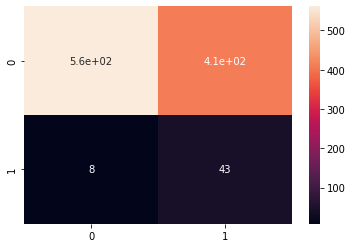

In [14]:
import seaborn as sns
sns.heatmap(cf, annot=True)
print(cf)

# Next two models

Now we split again to not have the val data for these models

In [15]:
X_train, X_test, y_train, y_test = data_loader.get_data_split(ANN = False)
print(X_train.shape)
print(X_test.shape)

# Oversample the train data 
X_train, y_train = data_loader.undersample(X_train, y_train)
print("After undersampling:", X_train.shape)

(4087, 20)
(1022, 20)
After undersampling: (396, 20)


### XGBoost


In [16]:
from xgboost import XGBClassifier
XGB = XGBClassifier(eval_metric= 'error')
XGB.fit(X_train, y_train) # Fit model
y_pred = XGB.predict(X_test) # Make predictions


print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)
XGB_performance = performance.evaluate(test_labels = y_test, predictions = y_pred)

              precision    recall  f1-score   support

           0       0.98      0.69      0.81       971
           1       0.11      0.75      0.19        51

    accuracy                           0.69      1022
   macro avg       0.55      0.72      0.50      1022
weighted avg       0.94      0.69      0.78      1022


Model Performance
Accuracy = 69.18%.
Recall strokes only = 74.51%.


[[669 302]
 [ 13  38]]


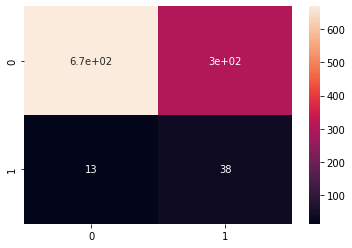

In [17]:
sns.heatmap(cf, annot = True)
print(cf)

### Random Forest

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train.values, y_train)
y_pred = rf.predict(X_test.values)
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)
XGB_performance = performance.evaluate(test_labels = y_test, predictions = y_pred)

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       971
           1       0.12      0.80      0.22        51

    accuracy                           0.71      1022
   macro avg       0.55      0.75      0.52      1022
weighted avg       0.94      0.71      0.79      1022


Model Performance
Accuracy = 70.74%.
Recall strokes only = 80.39%.


[[682 289]
 [ 10  41]]


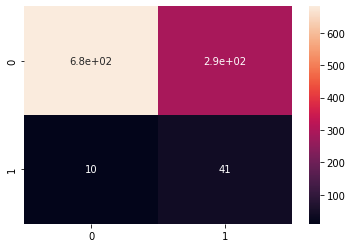

In [20]:
sns.heatmap(cf, annot = True)
print(cf)

We find that all three models have a hard time detecting the stroke patients while also keeping an overall high accuracy. 
I will try to optimize the hyperparameters of the Random Forest model to see if I can get a better performance. 

#### Tuning RF

We do a randomized search on hyperparameters. 
First we define a grid of parameters

In [21]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Random search and fit


In [22]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [23]:
# View best parameters from fitting
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

#### Evaluate Random search
Evaluate the random search based on recall of class 1 (stroke) only. 
Recall answers what proportion of actual positives aka strokes was identified correctly but in this case only among the stroke patients since this is the parameter that needs optimization. 

In [25]:
best_random = rf_random.best_estimator_
preds = best_random.predict(X_test)
print(classification_report(y_test,preds))
print()
cf = confusion_matrix(y_test,preds)
RF_performance = performance.evaluate(test_labels = y_test, predictions = preds)

              precision    recall  f1-score   support

           0       0.98      0.68      0.80       971
           1       0.11      0.76      0.19        51

    accuracy                           0.68      1022
   macro avg       0.55      0.72      0.50      1022
weighted avg       0.94      0.68      0.77      1022


Model Performance
Accuracy = 68.49%.
Recall strokes only = 76.47%.


[[661 310]
 [ 12  39]]


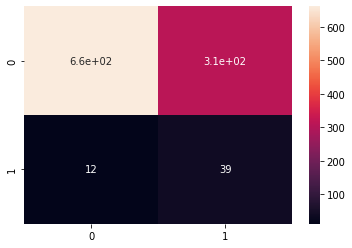

In [26]:
sns.heatmap(cf, annot = True)
print(cf)

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

#### Grid search (no difference in performance)

In [27]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [50, 60, 70],
    'max_features': [2, 4], # sqrt of total number of featuers in data
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [300, 500, 700, 900]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [28]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


{'bootstrap': False,
 'max_depth': 50,
 'max_features': 4,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'n_estimators': 300}

Evaluate the performance of the grid search

In [29]:
best_grid = grid_search.best_estimator_
preds = best_grid.predict(X_test)
print(classification_report(y_test,preds))
print()
cf = confusion_matrix(y_test,preds)
RF_performance = performance.evaluate(test_labels = y_test, predictions = preds)

              precision    recall  f1-score   support

           0       0.99      0.68      0.81       971
           1       0.12      0.82      0.21        51

    accuracy                           0.69      1022
   macro avg       0.55      0.75      0.51      1022
weighted avg       0.94      0.69      0.78      1022


Model Performance
Accuracy = 69.08%.
Recall strokes only = 82.35%.


[[664 307]
 [  9  42]]


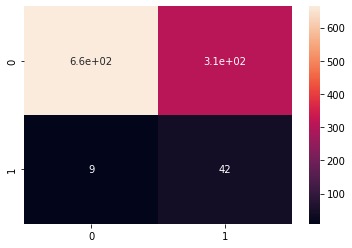

In [30]:
sns.heatmap(cf, annot = True)
print(cf)

Change threshold to make the model more sensitive to stroke cases   

              precision    recall  f1-score   support

           0       0.99      0.61      0.76       971
           1       0.11      0.90      0.19        51

    accuracy                           0.63      1022
   macro avg       0.55      0.76      0.48      1022
weighted avg       0.95      0.63      0.73      1022

[[595 376]
 [  5  46]]


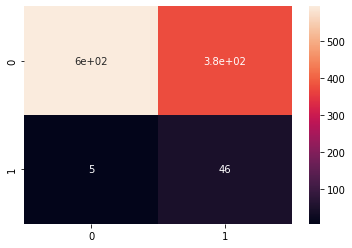

In [31]:
prediction_values = best_grid.predict_proba(X_test) # also try with the "best models"

threshold = 0.4
predicted = (prediction_values [:,1] >= threshold).astype('int')

print(classification_report(y_test, predicted))

cf__new_threshhold = confusion_matrix(y_test,predicted)
sns.heatmap(cf__new_threshhold, annot = True)
print(cf__new_threshhold)


A couple more stroke patients gets correctly classified but around 100 more incorecctly classified non-stroke patients. 

In [36]:
# Save model and data sets to use for interpretation
# save
import joblib
joblib.dump(best_grid, "./random_forest_best.joblib")
X_train.to_pickle("X_train.pkl")
X_test.to_pickle("X_test.pkl")
y_test.to_pickle("y_test.pkl")

# Interpretation

In [37]:
import joblib
model_interpret = joblib.load("./random_forest_best.joblib")

X_train = pd.read_pickle("X_train.pkl")
X_test = pd.read_pickle("X_test.pkl")
y_test = pd.read_pickle("y_test.pkl")

In [38]:
# Prep data
interpreter = InterpretModel(X_test, y_test)

# Filter out strokes instances
strokes_X_test, strokes_y_test = interpreter.prepare_data()

# Apply LIME
interpreter.LIME_method(model_interpret, X_train, strokes_X_test, strokes_y_test, 0, 51)


c:\Users\Bruger\anaconda3\envs\datascience\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

c:\Users\Bruger\anaconda3\envs\datascience\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

c:\Users\Bruger\anaconda3\envs\datascience\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

c:\Users\Bruger\anaconda3\envs\datascience\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

c:\Users\Bruger\anaconda3\envs\datascience\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

c:\Users\Bruger\anaconda3\envs\datascience\li

<!-- http://127.0.0.1:7001/2142201461296/ -->

In [39]:
# Apply SHAP
interpreter.SHAP_method(model_interpret, strokes_X_test, 0, 51)

c:\Users\Bruger\anaconda3\envs\datascience\lib\site-packages\shap\explainers\_tree.py:249: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



The RandomForestClassifier(bootstrap=False, max_depth=50, max_features=4,
                       min_samples_leaf=6, n_estimators=300) predicted: 0


c:\Users\Bruger\anaconda3\envs\datascience\lib\site-packages\shap\plots\_force.py:311: DeprecationWarning:

`np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

